In [1]:
import numpy as np
import cv2
import torch
from src.sim.ros.python3_ros_ws.src.handcrafted_cone_detection.helper_files.ArchitectureConfig import ArchitectureConfig
from src.sim.ros.python3_ros_ws.src.handcrafted_cone_detection.helper_files import cnn_architecture
from glob import glob
import os
import matplotlib.pyplot as plt
import time

In [3]:
def put_model_on_device(device: str = None):
    original_model_device = net.get_device()
    torch.device(device)

In [4]:
def downsample_image(image, factor=1):
    img = np.array(image, dtype='float32')
    img = torch.from_numpy(img.reshape(1, 1, img.shape[0], img.shape[1]))  # Convert grayscale image to tensor
    maxPool = torch.nn.AvgPool2d(factor)  # 4*4 window, maximum pooling with a step size of 4
    img_tensor = maxPool(img)
    img = torch.squeeze(img_tensor)  # Remove the dimension of 1
    img = img.numpy().astype('uint8')  # Conversion format, ready to output
    return img_tensor, img

In [5]:
def load_checkpoint(checkpoint_dir: str):
    if not checkpoint_dir.endswith('torch_checkpoints'):
        checkpoint_dir += '/torch_checkpoints'
    if len(glob(f'{checkpoint_dir}/*.ckpt')) == 0 and len(glob(f'{checkpoint_dir}/torch_checkpoints/*.ckpt')) == 0:
        raise FileNotFoundError
    # Get checkpoint in following order
    if os.path.isfile(os.path.join(checkpoint_dir, 'checkpoint_best.ckpt')):
        checkpoint_file = os.path.join(checkpoint_dir, 'checkpoint_best.ckpt')
    elif os.path.isfile(os.path.join(checkpoint_dir, 'checkpoint_latest.ckpt')):
        checkpoint_file = os.path.join(checkpoint_dir, 'checkpoint_latest.ckpt')
    else:
        checkpoints = {int(f.split('.')[0].split('_')[-1]): os.path.join(checkpoint_dir, f)
                       for f in os.listdir(checkpoint_dir)}
        checkpoint_file = checkpoints[max(checkpoints.keys())]
    # Load params for each experiment element
    checkpoint = torch.load(checkpoint_file, map_location=torch.device('cpu'))
    epoch = checkpoint['epoch'] if 'epoch' in checkpoint.keys() else 0
    for element, key in zip([net, trainer, environment],
                            ['net_ckpt', 'trainer_ckpt', 'environment_ckpt']):
        if element is not None and key in checkpoint.keys():
            element.load_checkpoint(checkpoint[key])
    print('checkpoint loaded')

In [6]:
def eval_neural_net(image):
    predictions = net.forward(image, train=False)
    np_pred = predictions.detach().numpy()
    return np_pred[0]

cnn_architecture - INFO - Started.
checkpoint loaded
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image test:
1.276061916503906
[ 3.189598    0.51013994 -1.4692924   5.5905247   1.3636389  -0.37082303]
[ 4.46566  0.76034 -0.40679  6.38991  2.00182  0.8475 ]
fps_average: 232.1918339057438
average error x: 0.6097521400508882m
average error y: 0.4481987383877039m
average error z: 0.3988720430792809m
average error x: 1.270063421824264m
average error y: 0.9966151702133892m
average error z: 0.6934941810116285m
error bias: -0.5410779986861748 dependant on distance: 0.4137722942204767


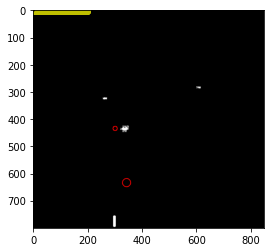

In [99]:
text_file_path = '/media/thomas/Elements/experimental_data/model_evaluation_handcrafted/data_collection_gazebo/raw_data/21-05-12_12-05-55/action.data'
#text_file_path = '/media/thomas/Elements/experimental_data/model_evaluation_handcrafted_single_cone/data_collection_gazebo/raw_data/21-05-12_20-28-33/action.data'
image_base_path = '/media/thomas/Elements/experimental_data/model_evaluation_handcrafted/data_collection_gazebo/raw_data/21-05-12_12-05-55/observation/'
#image_base_path = '/media/thomas/Elements/experimental_data/model_evaluation_handcrafted_single_cone/data_collection_gazebo/raw_data/21-05-12_20-28-33/observation/'
#text_file_path = '/media/thomas/Elements/experimental_data/200_res/data_collection_gazebo/raw_data/21-04-09_15-51-25/action.data'
#image_base_path = '/media/thomas/Elements/experimental_data/200_res/data_collection_gazebo/raw_data/21-04-09_15-51-25/observation/'
#image_base_path = '/media/thomas/Elements/experimental_data/200_res/data_collection_gazebo/raw_data/21-04-09_16-01-53/observation/'
#text_file_path = '/media/thomas/Elements/experimental_data/200_res/data_collection_gazebo/raw_data/21-04-09_16-01-53/action.data'

#text_file_path = '/media/thomas/Elements/experimental_data/model_evaluation_handcrafted_30_cone/data_collection_gazebo/raw_data/21-05-12_20-54-01/action.data'
#image_base_path = '/media/thomas/Elements/experimental_data/model_evaluation_handcrafted_30_cone/data_collection_gazebo/raw_data/21-05-12_20-54-01/observation/'

error_x = []
total_error_x = 0
total_error_y = 0
total_error_z = 0
total_error_x_1 = 0
total_error_y_1 = 0
total_error_z_1 = 0
nb_images = 200
tune_factor = 500
total_time = 0
distance_x = []
trainer = None
environment = None
architecture_config = ArchitectureConfig()
net = eval('cnn_architecture').Net(config=architecture_config) \
            if architecture_config is not None else None
load_checkpoint('/media/thomas/Elements/training_nn/res_200/6100_lr_0002')
put_model_on_device('cuda')
time_start =time.time()
total_time = 0
with open(text_file_path) as f:
    for image_idx in range(nb_images):
        ground_truth = f.readline().split()[2:8]
        ground_truth_np = np.array([float(ground_truth[0]),float(ground_truth[1]),float(ground_truth[2]),float(ground_truth[3]),float(ground_truth[4]),float(ground_truth[5])])
        
        #print(ground_truth_np)
        image_path = image_base_path+str(image_idx).zfill(15)+'.jpg'
        image = cv2.imread(image_path,-1)
        time_start = time.time()
        
        
        if np.amax(image) == 255:
            image_pr =image/255
        else:
            image_pr = image
        image_pr = noise_creation(image_pr)
        
        dwn_image_tens,dwn_image = downsample_image(image_pr,4)
        
        world_coor = eval_neural_net(dwn_image_tens)
        total_time +=(time.time()-time_start)
        #plt.imshow(dwn_image)
        #print(world_coor)
        current_error = abs(np.subtract(world_coor[0],ground_truth_np[0]))
        if image_idx in [1]:
            print(image_idx)
            cv2.imwrite('/media/thomas/Elements/test.png',dwn_image*255)
        else:
            distance_x.append(ground_truth_np[0])
            error_x.append(current_error)
            #total_error += current_error
            total_error_x += abs(np.subtract(world_coor[0],ground_truth_np[0]))
            total_error_y += abs(np.subtract(world_coor[1],ground_truth_np[1]))
            total_error_z += abs(np.subtract(world_coor[2],ground_truth_np[2]))
            total_error_x_1 += abs(np.subtract(world_coor[3],ground_truth_np[3]))
            total_error_y_1 += abs(np.subtract(world_coor[4],ground_truth_np[4]))
            total_error_z_1 += abs(np.subtract(world_coor[5],ground_truth_np[5]))
        if image_idx == :
            #plt.imshow(dwn_image*255,cmap='gray',vmax=255,vmin=0)
            print('image test:')
            print(current_error)
            print(world_coor)
            print(ground_truth_np)
            prop_image = np.zeros((800,848,3))
            prop_image[:,:,0] = image_pr*255
            prop_image[:,:,1] = image_pr*255
            prop_image[:,:,2] = image_pr*255
            np_pred = world_coor
            scaling_factor = 1

            x_position = int(-np_pred[1] / np_pred[0] * 505.3/scaling_factor + 424.5/scaling_factor)
            y_position = int(-np_pred[2] / np_pred[0] * 505.3/scaling_factor + 400.5/scaling_factor)
            cv2.circle(prop_image, (x_position,y_position), int(50/np_pred[0]/scaling_factor), (255,0,0), 2)
            x_position_1 = int(-np_pred[4] / np_pred[3] * 505.3/scaling_factor + 424.5/scaling_factor)
            y_position_1 = int(-np_pred[5] / np_pred[3] * 505.3/scaling_factor + 400.5/scaling_factor)
            cv2.circle(prop_image, (x_position_1,y_position_1), int(abs(50/np_pred[3]/scaling_factor)), (255,0,0), 2)
            plt.imshow(prop_image)
            cv2.imwrite('/media/thomas/Elements/befor_2.png',prop_image)
        #print(error)
print('fps_average: '+ str(nb_images/(total_time)))
gradient,intercept = np.polyfit(distance_x,error_x,1)
x1=np.linspace(1,5,500)
y1=gradient*x1+intercept
x = np.linspace(1,len(error_x),len(error_x))

plt.plot(x,error_x,'yo', x1, y1, '--k')
average_error_x = total_error_x/nb_images
average_error_y = total_error_y/nb_images
average_error_z = total_error_z/nb_images
average_error_x_1 = total_error_x_1/nb_images
average_error_y_1 = total_error_y_1/nb_images
average_error_z_1 = total_error_z_1/nb_images
print('average error x: '+str(average_error_x)+'m')
print('average error y: '+str(average_error_y)+'m')
print('average error z: '+str(average_error_z)+'m')
print('average error x: '+str(average_error_x_1)+'m')
print('average error y: '+str(average_error_y_1)+'m')
print('average error z: '+str(average_error_z_1)+'m')
print('error bias: '+str(intercept) +' dependant on distance: '+ str(gradient))

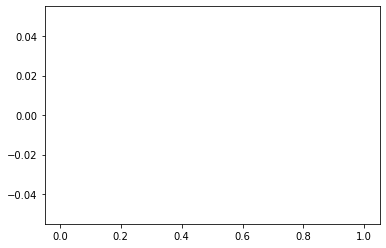

nan


/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
plt.hist(error_x, bins = 50)
plt.show()
print(np.std(error_x))

(200, 212)
255
cnn_architecture - INFO - Started.
checkpoint loaded
[ 2.6314826   0.76101875 -1.2527726   4.595373    1.0169867  -0.55408764]


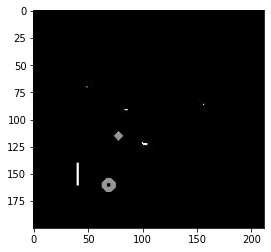

In [52]:
path ='/media/thomas/Elements/experimental_data/200_res/data_collection_gazebo/raw_data/21-04-09_16-01-53/observation/000000000000197.jpg'
prop_image = cv2.imread(path,-1)
print(prop_image.shape)
print(np.amax(prop_image))
cv2.rectangle(prop_image,(40,140),(41,160),(255),1)
#cv2.circle(prop_image, (100,100), 5, 255, 5)
#cv2.circle(prop_image, (100,150), 1, 255, 5)
#cv2.circle(prop_image, (100,150), 15, 255, 20)
#prop_image[0:50,:] = 0

trainer = None
environment = None
architecture_config = ArchitectureConfig()
net = eval('cnn_architecture').Net(config=architecture_config) \
            if architecture_config is not None else None
load_checkpoint('/media/thomas/Elements/training_nn/res_200/6100_lr_0002')
put_model_on_device('cuda')
netwr_image = prop_image/255
dwn_image_tens,dwn_image = (downsample_image(netwr_image,1))
np_pred = eval_neural_net(dwn_image_tens)

print(np_pred)
plt.imshow(prop_image,cmap='gray')
scaling_factor = 4
x_position = int(-np_pred[1] / np_pred[0] * 505.3/scaling_factor + 424.5/scaling_factor)
y_position = int(-np_pred[2] / np_pred[0] * 505.3/scaling_factor + 400.5/scaling_factor)
cv2.circle(prop_image, (x_position,y_position), int(50/np_pred[0]/scaling_factor), 150, int(15/scaling_factor))
x_position_1 = int(-np_pred[4] / np_pred[3] * 505.3/scaling_factor + 424.5/scaling_factor)
y_position_1 = int(-np_pred[5] / np_pred[3] * 505.3/scaling_factor + 400.5/scaling_factor)
cv2.circle(prop_image, (x_position_1,y_position_1), int(abs(50/np_pred[3]/scaling_factor)), 150, int(15/scaling_factor))

plt.imshow(prop_image,cmap='gray')

In [77]:
def noise_creation(image):
    [width,height] = image.shape
    x = int(np.random.rand()*width)
    y = int(np.random.rand()*height)
    length = int(np.random.rand()*50)
    bre = int(np.random.rand()*50)
    cv2.rectangle(image,(x,y),(x+length,y+bre),1,4)
    return image

In [11]:
gr_th = np.array([1.09099, -0.18821, 0.10408, 2.83883, -0.47011, 1.13297])

estimation_clean_original = np.array([ 1.0994427,  -0.22244957,  0.13334689,  2.7808475,  -0.54785246,  0.88644224])
estimation_single_cone = np.array([1.0788105  -0.16984475  0.13799319 3.3793888  -1.0458415   1.0864222])
estim_with_cirlce = np.array([1.0008508,  -0.12048292,  0.26899752,  2.391978,   -0.49274975,  1.1117944])



SyntaxError: invalid syntax (<ipython-input-11-8ebce0e3f7d4>, line 4)

True

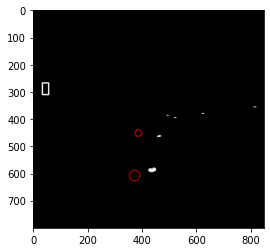

In [7]:
image_tf = cv2.imread('/media/thomas/Elements/after_2.png')
plt.imshow(image_tf)
cv2.imwrite('/media/thomas/Elements/after_2.png', cv2.cvtColor(image_tf, cv2.COLOR_RGB2BGR))